# Head pose Estimation
### I have in dataset the images that contains the face land marks, and .mat file that contain pitch,yaw and roll
### I should use tha landmarks to predict the angles (pitch,yaw and roll)

In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 15.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from xgboost import XGBRegressor

In [3]:
from sklearn.model_selection import train_test_split,GridSearchCV

In [4]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR,SVC

In [5]:
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler,StandardScaler

In [6]:
from sklearn.preprocessing import normalize

In [7]:
from sklearn.metrics import mean_absolute_error

In [ ]:
!unzip '/content/drive/MyDrive/AFLW2000-3D.zip'

### I should extract the files.mat and store them in file_names

In [9]:
file_names = sorted([Path(f).stem for f in glob.glob("AFLW2000/*.mat")])

### I will extract the face landmarks, each landmark has point(x,y),so I will extract face landmark.x in x_points, and extract face landmark.y in y_points
### I also will extract the files.mat if it exist and not empty and take just pitch,yaw and roll, and put them in labels.
### I also will the files.mat themselves in detected_files

In [10]:
x_points= []
y_points = []
labels = []
detected_files = []



# detecting faces and extracting the points
faceModule = mediapipe.solutions.face_mesh
# looping over the file names to load the images and their corresponding mat file

for filename in file_names:
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('AFLW2000/'+filename+'.jpg')
    # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
          # appending the file names where have been detected.
          detected_files.append(filename)
          # detecting the face
          face = results.multi_face_landmarks[0]
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          # looping over the 468 points of x and y
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image.
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # X_features
              X.append(relative_x)
              # Y_features
              Y.append(relative_y)

          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          # appending the points of the images in the list of all image points
          x_points.append(X)
          y_points.append(Y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

# converting features and labels to 2D array
x_points = np.array(x_points)
y_points = np.array(y_points)
labels = np.array(labels)

# the first label (pitch)
pitch_label = labels[:,0]
# the first label (yaw)
yaw_label = labels[:,1]
# the first label (roll)
roll_label = labels[:,2]


In [11]:
print(x_points.shape)
print(y_points.shape)
print(labels.shape)

(1853, 468)
(1853, 468)
(1853, 3)


### Normalizing the the face landmarks in every image is very important,so I will subtract the nose point from each point to center them around the nose(which is point 4 in my arrays), then devide the result all point on the distance between the nose and head or chain.

In [12]:
x_center = x_points - x_points[:,4].reshape(-1,1)
y_center = y_points - y_points[:,4].reshape(-1,1)

# normalizing the data 
X_4 = x_points[:,4]
X_10 = x_points[:,10]
Y_4 = y_points[:,4]
Y_10 = y_points[:,10]

# computing the distance
distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_4,Y_4)),axis = 0).reshape(-1,1)
Norm_x = x_center / distance
Norm_y = y_center / distance
final_x = Norm_x
final_y = Norm_y
features = np.hstack([final_x,final_y])

In [38]:
features.shape

(1853, 936)

## Spliting the data.

In [39]:
X_train,X_test,y_train,y_test,file_train,file_test = train_test_split(features,labels,detected_files,test_size = 0.2,random_state = 20)

## Choosing the best model for each angle,after many tries,I will choose SVR that have the best or least mean absolute error and (((( the error of the train is less than the test))).

In [51]:
# model for pitch.
svr_pitch_predict = SVR(C=10, kernel = 'poly')
svr_pitch_predict.fit(X_train,y_train[:,0])
y_pitch = svr_pitch_predict.predict(X_test)
print("Accuracy= ",svr_pitch_predict.score(X_test,y_test[:,0]))
print("Mean abs Error_test= ",mean_absolute_error(y_test[:,0], y_pitch))
y_pitch_train = svr_pitch_predict.predict(X_train)
print("Mean Square Error_train= ",mean_absolute_error(y_train[:,0], y_pitch_train))

Accuracy=  0.49749239731762973
Mean abs Error_test=  0.09874790669826629
Mean Square Error_train=  0.09631787487875672


In [45]:
# model for yaw.
svr_yaw_predict = SVR(C=10, kernel = 'linear')
svr_yaw_predict.fit(X_train,y_train[:,1])
y_yaw = svr_yaw_predict.predict(X_test)
print("Accuracy= ",svr_yaw_predict.score(X_test,y_test[:,1]))
print("Mean abs Error_test= ",mean_absolute_error(y_test[:,1], y_yaw))
y_yaw_train = svr_yaw_predict.predict(X_train)
print("Mean Square Error_train= ",mean_absolute_error(y_train[:,1], y_yaw_train))

Accuracy=  0.9495675466942693
Mean abs Error_test=  0.07698238679968172
Mean abs Error_train=  0.07242369223296628


In [47]:
# model for roll.
svr_roll_predict = SVR(C=10, kernel = 'rbf')
svr_roll_predict.fit(X_train,y_train[:,2])
y_roll = svr_roll_predict.predict(X_test)
print("Accuracy= ",svr_roll_predict.score(X_test,y_test[:,2]))
print("Mean abs Error_test= ",mean_absolute_error(y_test[:,2], y_roll))
y_roll_train = svr_roll_predict.predict(X_train)
print("Mean abs Error_train= ",mean_absolute_error(y_train[:,2], y_roll_train))

Accuracy=  0.6461333187123774
Mean abs Error_test=  0.07884363267974132
Mean abs Error_train=  0.07755551108675239


## Draw Axes.

In [28]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

## Extract from Image and testing.

In [52]:
random_file = '/content/AFLW2000/image00008.jpg'

In [57]:
from google.colab.patches import cv2_imshow

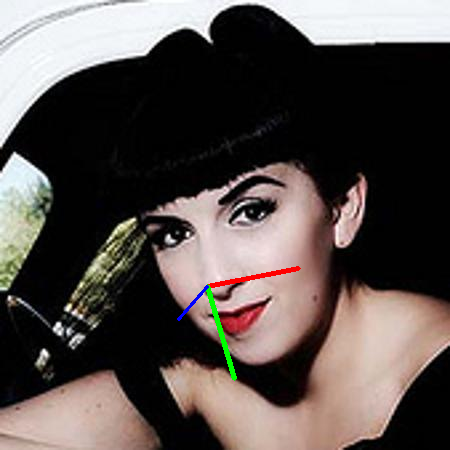

In [60]:
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  image = cv2.imread(random_file)
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        X = []
        Y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            # getting the points back to its actual values
            shape = image.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # appending the points to the X and Y lists
            X.append(relative_x)
            Y.append(relative_y)

        # converting the x and y points to numpy array
        X = np.array(X)
        Y = np.array(Y)

        # centering the points of x and y values arround the point no. 4
        x_center = X - X[4]
        y_center = Y - Y[4]
        # computing the distance between the point 4 and 10
        d = np.linalg.norm(np.array((X[4],Y[4])) - np.array((X[10],Y[10])))
        # normalizing the points
        X_norm = x_center/d
        Y_norm = y_center/d
        X_norm = X_norm
        Y_norm = Y_norm
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = svr_pitch_predict.predict(points)
        pred_yaw = svr_yaw_predict.predict(points)
        pred_roll = svr_roll_predict.predict(points)
        
        draw_axis(image,pred_pitch,pred_yaw,pred_roll,X[4],Y[4])
        
        x_nose, x_corner,x_corner2 = face.landmark[4].x , face.landmark[10].x ,face.landmark[152].x
        y_nose, y_corner,y_corner2 = face.landmark[4].y , face.landmark[10].y,face.landmark[152].y

        relative_x_nose, relative_x_corner,relative_x_corner2 = int(x_nose * shape[1]), int(x_corner * shape[1]),int(x_corner2 * shape[1])
        relative_y_nose , relative_y_corner,relative_y_corner2 = int(y_nose * shape[0]), int(y_corner * shape[0]),int(y_corner2 * shape[0])
        
        cv2_imshow(image)

## Testing on video

In [61]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Hamsa_ML1.mp4')
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video file")

# initializing a list to store the frames   
img_array = []
# Read until video is completed
while(cap.isOpened()):   
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
      with faceModule.FaceMesh(static_image_mode=True) as face:
        # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
        results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          for face in results.multi_face_landmarks:
              # initializing X and Y lists to store the spacial coordinates of the points
              X = []
              Y = []
              # looping over the landmarks to extract x and y
              for j,landmark in enumerate(face.landmark):
                  x = landmark.x
                  y = landmark.y
                  # retrieve the true values of x and y
                  shape = frame.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  X.append(relative_x)
                  Y.append(relative_y)
              X = np.array(X)
              Y = np.array(Y)
              # centering the data arround the point 4
              x_center = X - X[4]
              y_center = Y - Y[4]
              d = np.linalg.norm(np.array((X[4],Y[4])) - np.array((X[10],Y[10])))
              X_norm = x_center/d
              Y_norm = y_center/d
              X_norm = X_norm
              Y_norm = Y_norm
              points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
              # predicting the 3 angels to draw the axis on the image
              pred_pitch = svr_pitch_predict.predict(points)
              pred_yaw = svr_yaw_predict.predict(points)
              pred_roll = svr_roll_predict.predict(points)
              draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[4],Y[4])
              # appending the result frame to the img_array list
              img_array.append(frame)
    # Break the loop
    else: 
        break

cap.release()  
# Closes all the frames
cv2.destroyAllWindows()
# converting the frames to video
out = cv2.VideoWriter('Hamsa.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()